In [457]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [458]:
data = yf.download('ETH-USD',start='2018-01-01', end='2025-01-01', interval='1d')
data.sort_index(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523


In [459]:
data.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=2557, freq=None)

As we can see, the dataset is already formatted to have the date as the index along with its datatype being in the correct datetime format.
No form of index resetting is required.

In [460]:
data.columns

MultiIndex([( 'Close', 'ETH-USD'),
            (  'High', 'ETH-USD'),
            (   'Low', 'ETH-USD'),
            (  'Open', 'ETH-USD'),
            ('Volume', 'ETH-USD')],
           names=['Price', 'Ticker'])

In [461]:
# Flatten Multi-index to get only the first level
data.columns = data.columns.get_level_values(0)
# Remove Multi-index column list name
data.columns.name = None
data.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [462]:
print('Column datatypes')
print(data.dtypes)
print('\nEmpty Cells Present?')
print(data.isna().sum())
print('\nNull Values Present?')
print(data.isnull().sum())

Column datatypes
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Empty Cells Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

Null Values Present?
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [463]:
data

,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,772.640991,782.530029,742.004028,755.757019,2595760128
2018-01-02,884.443970,914.830017,772.346008,772.346008,5783349760
2018-01-03,962.719971,974.471008,868.450989,886.000000,5093159936
2018-01-04,980.921997,1045.079956,946.085999,961.713013,6502859776
2018-01-05,997.719971,1075.390015,956.325012,975.750000,6683149824
...,...,...,...,...,...
2024-12-27,3328.916992,3436.710693,3302.575684,3331.053711,24091627403
2024-12-28,3397.902344,3419.920166,3318.033936,3328.774658,14305648523
2024-12-29,3349.513428,3406.648438,3321.664795,3397.862549,13440907792


## Exploratory Data Analysis (EDA)

In [464]:
data.describe()

,Close,High,Low,Open,Volume
count,2557.000000,2557.000000,2557.000000,2557.000000,2.557000e+03
mean,1511.365150,1551.575457,1465.607665,1510.525290,1.324921e+10
std,1231.080013,1263.858373,1194.403502,1230.923701,1.057707e+10
min,84.308296,85.342743,82.829887,84.279694,9.484880e+08
25%,262.331726,269.641235,249.111847,262.388641,5.863109e+09
50%,1469.741699,1541.334717,1423.264771,1461.133179,1.080788e+10
75%,2431.946533,2498.507080,2340.920410,2429.980957,1.788020e+10
max,4812.087402,4891.704590,4718.039062,4810.071289,8.448291e+10


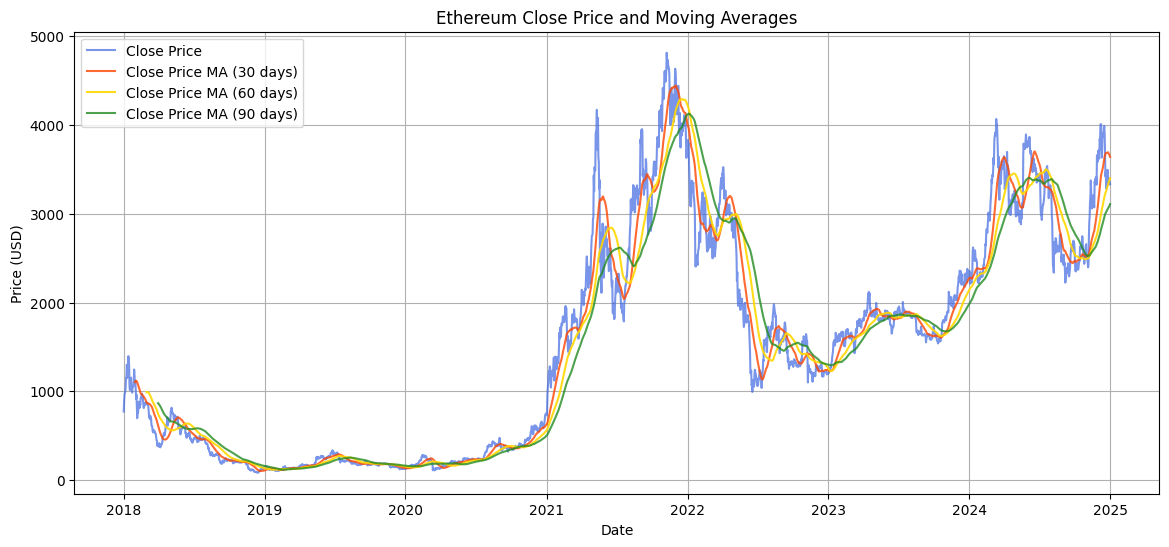

In [465]:
plt.figure(figsize=(14, 6))

# Lineplots of Closing Price and Moving Averages of 30, 60, & 90 days
sns.lineplot(data=data, x=data.index, y=data['Close'], alpha=0.7, color='royalblue', label='Close Price')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=30).mean(), alpha=0.8, color='orangered', label='Close Price MA (30 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=60).mean(), alpha=0.9, color='gold', label='Close Price MA (60 days)')
sns.lineplot(data=data, x=data.index, y=data['Close'].rolling(window=90).mean(), alpha=0.8, color='forestgreen', label='Close Price MA (90 days)')

plt.title('Ethereum Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Strong evidence that the data is not stationary. This confirms our non-stationary assumption from visual inspection.

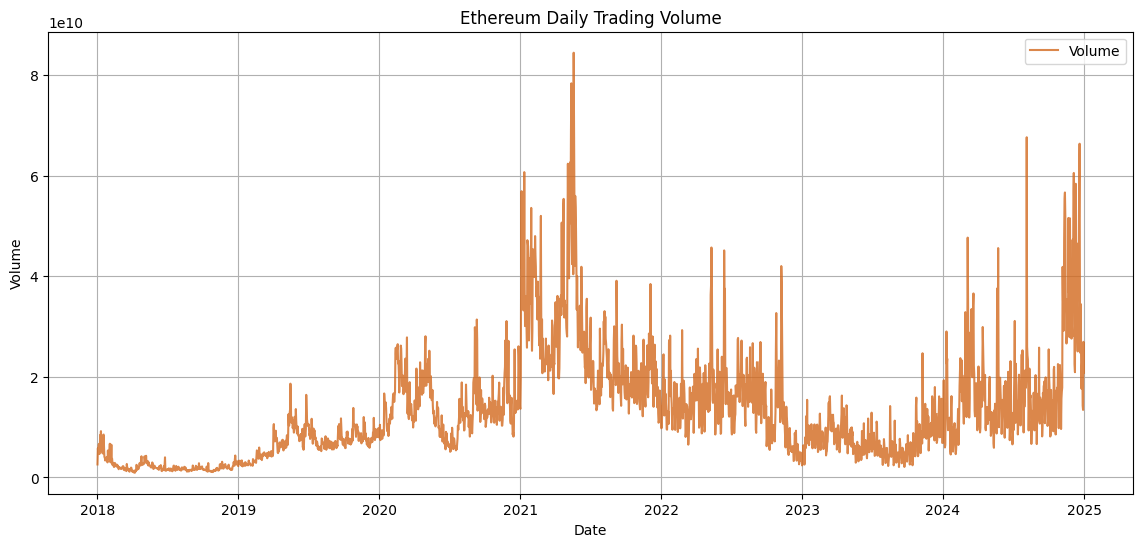

In [466]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data.index, y=data['Volume'], alpha=0.8, color='chocolate', label='Volume')
plt.title('Ethereum Daily Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

<Figure size 1400x600 with 0 Axes>

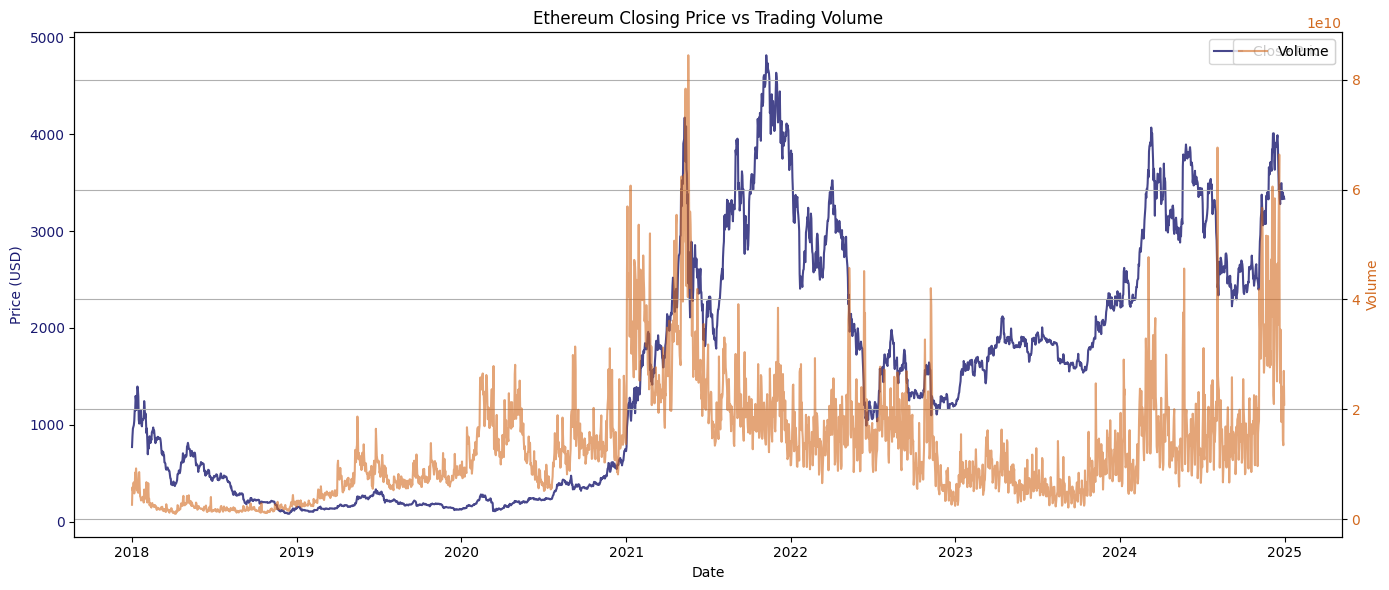

In [467]:
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Closing Price Plot
sns.lineplot(ax=ax1, data=data, x=data.index, y='Close', color='midnightblue', alpha=0.8, label='Close Price')
ax1.set_ylabel('Price (USD)', color='midnightblue')
ax1.tick_params(axis='y', labelcolor='midnightblue')

# Trading Volume Plot
ax2 = ax1.twinx()
sns.lineplot(ax=ax2, data=data, x=data.index, y='Volume', color='chocolate', alpha=0.6, label='Volume')
ax2.set_ylabel('Volume', color='chocolate')
ax2.tick_params(axis='y', labelcolor='chocolate')

plt.title('Ethereum Closing Price vs Trading Volume')
ax1.set_xlabel('Date')
fig.tight_layout()
plt.grid(True)
plt.show()

In [468]:
# Function to perform Augmented Dickey Fuller test
def adf_test (data, title):
    result = adfuller(data)
    print(f'{title} ADF Test')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

# Check for stationarity using Augmented Dickey Fuller test
adf_test(data['Close'], title='Close Price')

Close Price ADF Test
ADF Statistic: -1.2266310439660848
p-value: 0.6620360962440417


In [469]:
eth_returns = data['Close'].pct_change().dropna()
eth_diff = data['Close'].diff().dropna()

print(f'Percentage change/Returns:\n{eth_returns}')
print(f'\nFirst difference:\n{eth_diff}')

Percentage change/Returns:
Date
2018-01-02    0.144702
2018-01-03    0.088503
2018-01-04    0.018907
2018-01-05    0.017125
2018-01-06    0.044061
                ...   
2024-12-27   -0.000693
2024-12-28    0.020723
2024-12-29   -0.014241
2024-12-30    0.002054
2024-12-31   -0.007109
Name: Close, Length: 2556, dtype: float64

First difference:
Date
2018-01-02    111.802979
2018-01-03     78.276001
2018-01-04     18.202026
2018-01-05     16.797974
2018-01-06     43.960083
                 ...    
2024-12-27     -2.308838
2024-12-28     68.985352
2024-12-29    -48.388916
2024-12-30      6.879150
2024-12-31    -23.860840
Name: Close, Length: 2556, dtype: float64


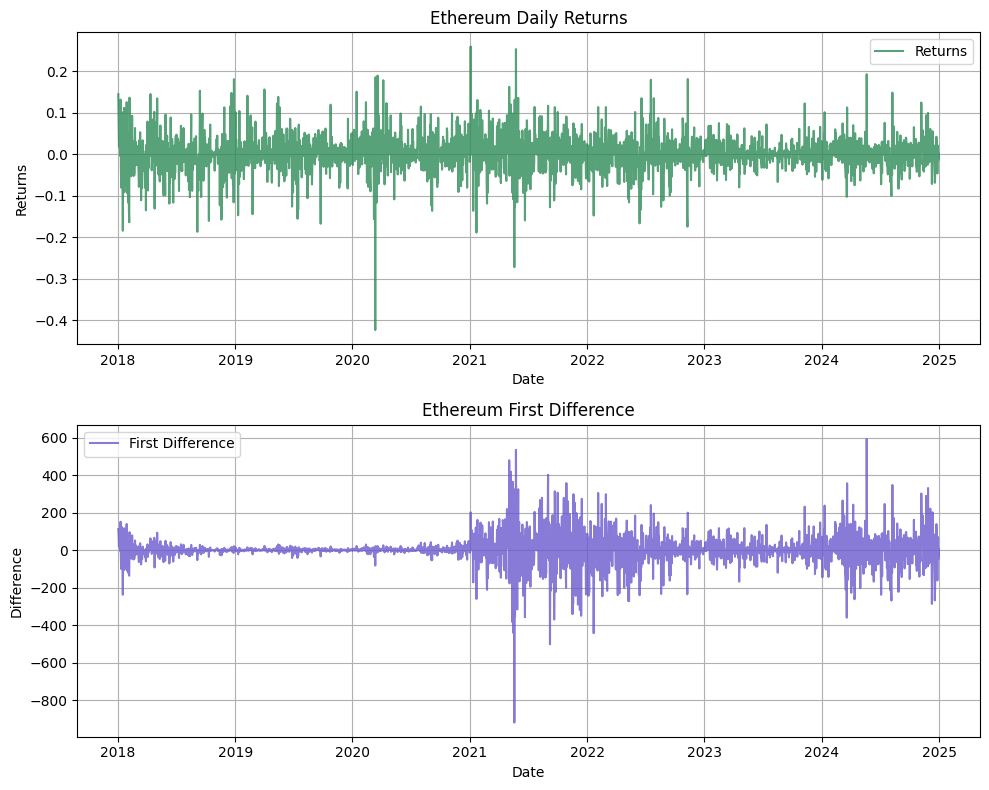

In [470]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot Returns
sns.lineplot(ax=axes[0], x=eth_returns.index, y=eth_returns.values, color='seagreen', label='Returns', alpha=0.8)
axes[0].set_title('Ethereum Daily Returns')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Returns')
axes[0].grid(True)

# Plot First Differences
sns.lineplot(ax=axes[1], x=eth_diff.index, y=eth_diff.values, color='slateblue', label='First Difference', alpha=0.8)
axes[1].set_title('Ethereum First Difference')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [471]:
adf_test(data=eth_returns, title='Returns')
print()
adf_test(data=eth_diff, title='First Difference')

Returns ADF Test
ADF Statistic: -15.266983458813222
p-value: 4.774396895151701e-28

First Difference ADF Test
ADF Statistic: -12.53846364258021
p-value: 2.3431118738983896e-23


The **Returns** and **Closing Price First Difference** graph shows strong stationarity as indicated by the ADF Test

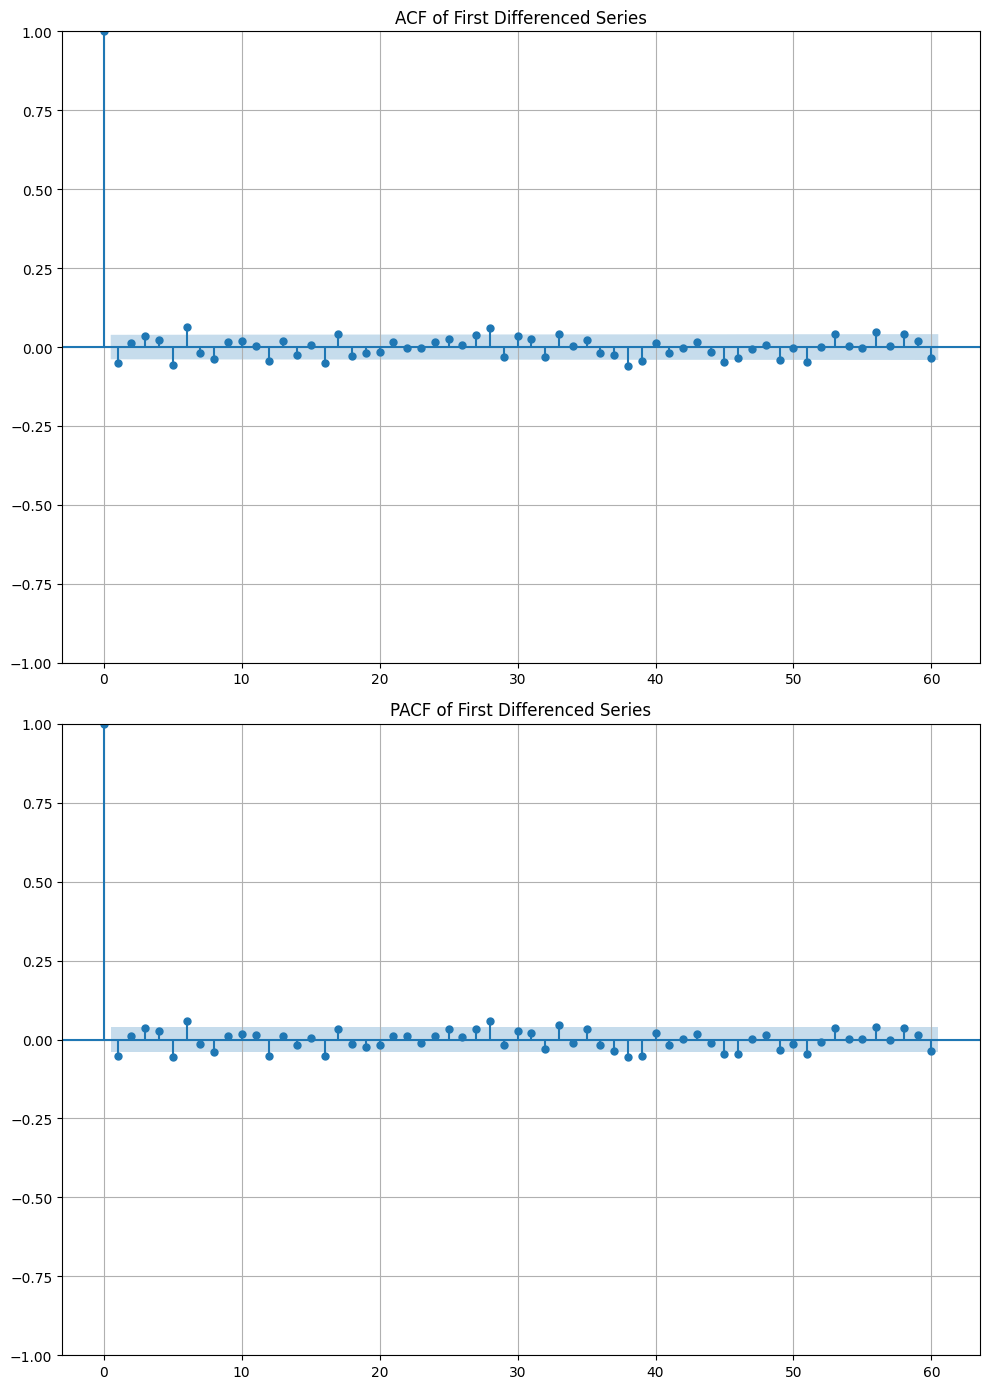

In [472]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 14))

# Plot ACF
plot_acf(eth_diff, lags=60, ax=axes[0])
axes[0].set_title('ACF of First Differenced Series')
axes[0].grid(True)

# Plot PACF
plot_pacf(eth_diff, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF of First Differenced Series')
axes[1].grid(True)

plt.tight_layout()
plt.show()

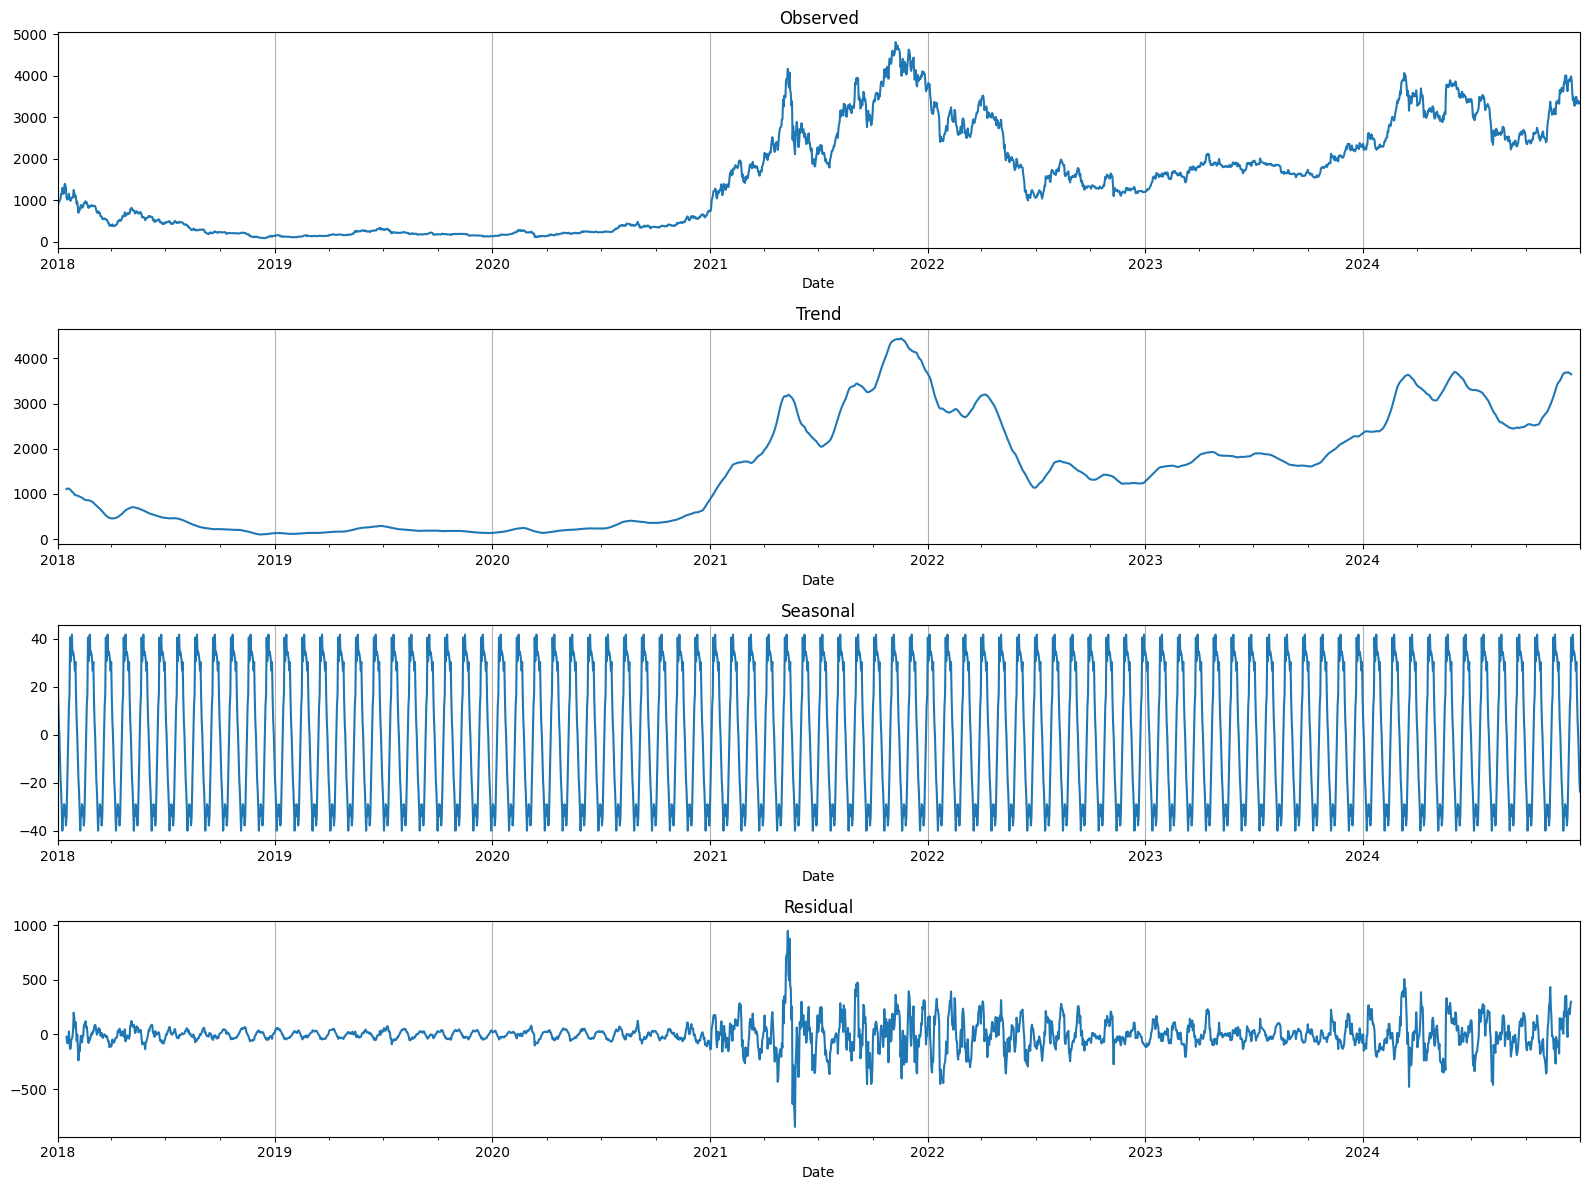

In [ ]:
# Perform decomposition
decomposition = seasonal_decompose(data['Close'], model='additive', period=30)

# Set larger figure size
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Plot each component
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')

axes[0].grid(axis='x'), axes[1].grid(axis='x'), axes[2].grid(axis='x'), axes[3].grid(axis='x')
plt.tight_layout()
plt.show()

Looks like there is some seasonal component influencing the overall trend.

In [474]:
train_data = data[data.index < '2024-12-01']['Close']
test_data = data[data.index >= '2024-12-01']['Close']

In [480]:
arima = ARIMA(train_data, order=(3,1,3))
model_fit = arima.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2526
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -14599.507
Date:                Sat, 03 May 2025   AIC                          29213.014
Time:                        20:10:54   BIC                          29253.852
Sample:                    01-01-2018   HQIC                         29227.832
                         - 11-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1522      0.093    -12.362      0.000      -1.335      -0.970
ar.L2         -1.2008      0.025    -47.819      0.000      -1.250      -1.152
ar.L3         -0.8573      0.089     -9.685      0.000      -1.031      -0.684
ma.L1          1.1162      0.097     11.547      0.000       0.927       1.306
ma.L2          1.1999      0.024     50.767      0.000       1.154       1.246
ma.L3          0.8639      0.095      9.049      0.000       0.677       1.051
sigma2      6213.9778     68.466     90.760      0.000    6079.786    6348.169
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):             22623.62
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               8.81   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [481]:
arima_predictions = model_fit.forecast(len(test_data))
arima_residuals = test_data - arima_predictions

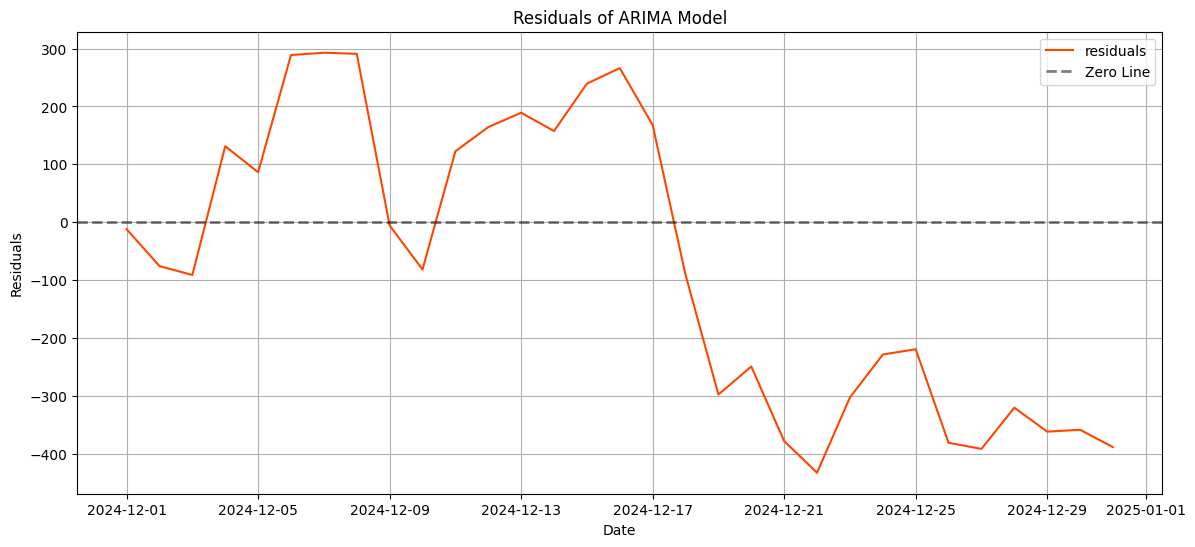

In [482]:
plt.figure(figsize=(14, 6))
sns.lineplot(x=test_data.index, y=arima_residuals, color='orangered', label='residuals')
#plt.plot(test_data.index, arima_residuals, color='blue', label='Residuals', alpha=0.8)
plt.axhline(y=0, color='black', label='Zero Line', linewidth ='2', linestyle='--', alpha=0.5)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

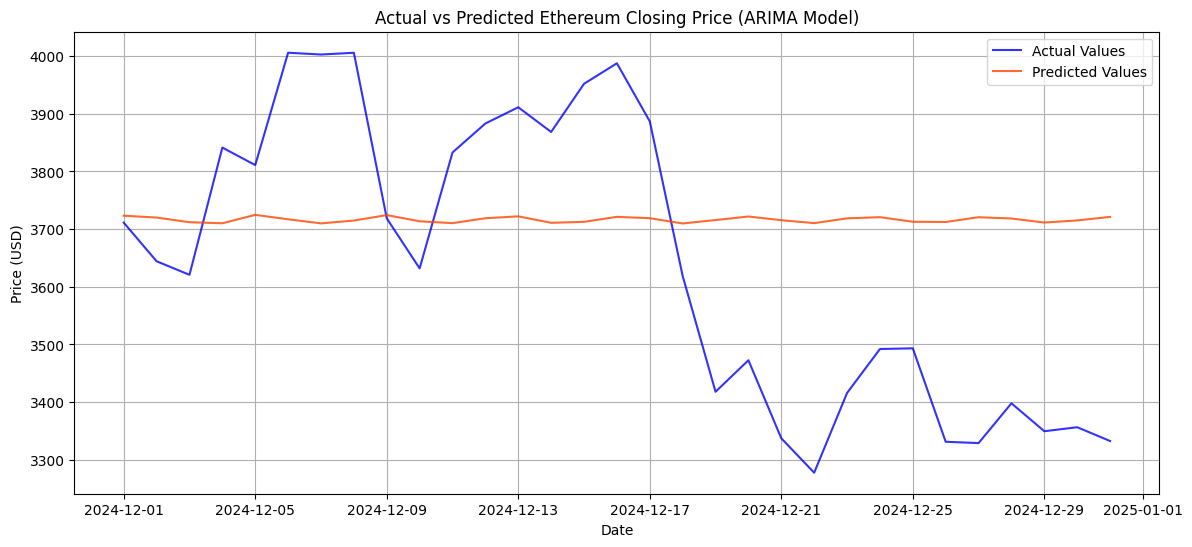

In [483]:
# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, color='blue', label='Actual Values', alpha=0.8)
plt.plot(test_data.index, arima_predictions, color='orangered', label='Predicted Values', alpha=0.8)
plt.title('Actual vs Predicted Ethereum Closing Price (ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [484]:
mae = mean_absolute_error(test_data, arima_predictions)
mse = mean_squared_error(test_data, arima_predictions)
rmse = root_mean_squared_error(test_data, arima_predictions)
mape = mean_absolute_percentage_error(test_data, arima_predictions)
r2 = r2_score(test_data,arima_predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R^2 Score (R2): {r2}')

Mean Absolute Error (MAE): 227.91908844901178
Mean Squared Error (MSE): 66182.82585435455
Root Mean Squared Error (RMSE): 257.2602298342178
Mean Absolute Percentage Error (MAPE): 0.06406431414696999%
R^2 Score (R2): -0.08791218008855073
